In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt


In [9]:
mass0=[15.9994,1.00794,15.9994,1.00794]
mass = np.zeros(4)
for i in range(4):
    mass[i] = mass0[i]*1836.0

In [10]:
print(mass)

[29374.8984   1850.57784 29374.8984   1850.57784]


In [12]:
coord = np.genfromtxt('HOOH.dat')
## O H O H
##
## 2-1-3-4


In [13]:
print(np.shape(coord))

(4, 3)


In [15]:
v1 = coord[1,:]-coord[2,:]
v2 = coord[3,:]-coord[1,:]
print(v1)
print(v2)

[-1.6094  0.8226  0.49  ]
[ 1.7879 -1.6356  0.    ]


In [19]:
ll = 0.0
for i in range(3):
    ll += v1[i]**2
    
ll = np.sqrt(ll)
print(ll)

1.872682332911805


In [18]:
print(np.linalg.norm(v1))

1.872682332911805


# $\sum_{{\rm{bonds}}}K_{b}(b-b_0)^2+\sum_{\rm{angles}}K_{\theta}(\theta-\theta_0)^2+
\sum_{\rm{dihedrals}}K_{\phi}(1+\cos{(n\phi-\delta)}) +
\sum_{nb}\left\{\frac{q_{i}q_{j}}{4\pi D r_{ij}} + \varepsilon_{ij}\left[
\Big(\frac{R_{\rm{min},ij}}{r_{ij}}\Big)^{12} - 2\Big(\frac{R_{\rm{min},ij}}{r_{ij}}\Big)^{6}
\right]\right\}
$

# In this case, we first set the partial charges of all atoms as zero.

In [ ]:
def bond(x,ia,ib):
    b = 0.0
    for k in range(3):
        b += (x[ia,k]-x[ib,k])**2
    b = np.sqrt(b)
    return b
def angle(x,ia,ib,ic):
    v1 = x[ib,:]-x[ia,:]
    v2 = x[ic,:]-x[ib,:]
    denom = np.linalg.norm(v1)*np.linalg.norm(v2)
    a = np.dot(v1,v2)/denom
    return a
def dihedral(x,ia,ib,ik,il):
    v1 = x[ib,:]-x[ia,:]
    v2 = x[ik,:]-x[ib,:]
    v3 = x[il,:]-x[ik,:]
    eijk = np.cross(v1,v2)
    eijk = eijk / np.linalg.norm(eijk)
    ejkl = np.cross(v2,v3)
    ejkl = ejkl / np.linalg.norm(ejkl)
    uijkl = np.dot(eijk,ejkl)
    theta = np.arccos(uijkl)
    return theta

def pot(x):
    Kb1 = 469365.3 ## OH
    b10 = 0.9720   ## OH
    Kb2 = 246184.9 ## OO
    b20 = 1.4490   ## OO
    Ka  = 820.21   ## H-O-O
    ang0= 95.6970  ## H-O-O
    phi0= 180.0    ## H-O-O-H
    fu  = 9        ## H-O-O-H
    kphi= -4.184   ## H-O-O-H
    nn  = 2        ## H-O-O-H
    
    epsilon = 0.192464 
    sigma   = 0.040001
    
    b1  = bond(x,1,2) ## H-O
    b2  = bond(x,1,3) ## O-O
    b3  = bond(x,3,4) ## O-H
    Vb  = Kb1*(b1-b1)+Kb2*(b2-b20) + Kb1*(b3-b10)
    ang1= angle(x,2,1,3)
    ang2= angle(x,2,3,4)
    Va  = Ka*(ang1-ang0)+Ka*(ang2-ang0)
    dih = dihedral(x,2,1,3,4)
    Vd  = Kphi*(1.0+cos(nn*dih-fu))
    
    ## V14, the van der Waals interaction.
    d12 = bond(x,2,4)
    p12 = sigma/d12
    p12_12 = p12**12
    p12_6  = p12**6
    V14 = epsilon*(p12_12-2.0*p12_6)
    
    ## Here we omitted the electronic interaction.
    ## partial charge: O: -0.4 a.u., H: +0.4 a.u.

    potential = Vb+Va+Vd+V14
    
    return potential

def gradient(x):
    '''
    Central defferential for dV/dx.
    '''
    h = 1.0E-4
    two_h = 2.0*h
    Natoms, Nd = np.shape(x)
    dVdx = np.zeros((Natoms,Nd))
    for i in range(Natoms):
        for j in range(Nd):
            x[i,j] = x[i,j]+h
            Vf = pot(x)
            x[i,j] = x[i,j]-h
            
            x[i,j] = x[i,j]-h
            Vb = pot(x)
            x[i,j] = x[i,j]+h
            
            dVdx[i,j] = (Vf-Vb)/twoh
    return dVdx

def COM(x,mass):
    '''
    Calculate the center of mass of the whole molecule.
    '''
    Natoms,Nd = np.shape(x)
    COM = np.zeros(Nd)
    for j in range(Nd):
        mass_t = 0.0
        for i in range(Natoms):
            COM[j] += mass[i]*x[i,j]
            mass_t += mass[i]
        COM[j] = COM[j]/mass_t
    return COM


In [2]:
import numpy as np

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font',family='serif',size='16')
fig = plt.figure(1,figsize=(7,5))
#fig = plt.figure(1,figsize=(7, 5)) ## To save figure.

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)   

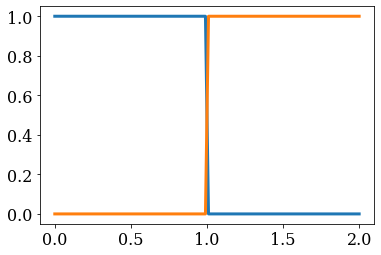

In [5]:
x = np.arange(0,2+0.01,0.01)
HB = np.heaviside(x-1.0,0.5)
HA = np.heaviside(1.0-x,0.5)

plt.plot(x,HA,'-',lw=3)
plt.plot(x,HB,'-',lw=3)
plt.show()

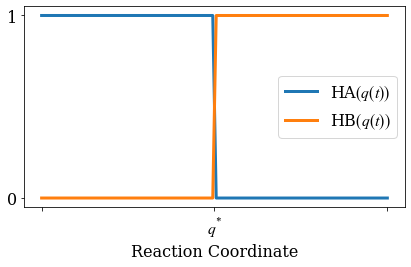

In [8]:
plt.plot(x,HA,'-',lw=3,label=r"HA$(q(t))$")
plt.plot(x,HB,'-',lw=3,label=r"HB$(q(t))$")
plt.xlabel('Reaction Coordinate')

plt.xticks([0,1,2],['',r"$q^{*}$",''])
plt.yticks([0,1],['0','1'])
plt.legend(loc='best')
figname = 'RC.png'
plt.tight_layout()
plt.savefig(figname,format='png',dpi=300)
plt.show()

<Figure size 504x360 with 0 Axes>